# Algorithm Comparison
Sets up a reproducible environment for comparing clustering performance on our processed single-cell RNA-seq datasets. It evaluates and contrasts three approaches:

* ScDCC – deep constrained clustering with limited domain knowledge
* K-Means – traditional centroid-based clustering 
* DEC – deep embedded clustering

Provides a common, reproducible framework to run and compare all methods on the same processed dataset. Demonstrates that limited domain knowledge models (ScDCC) can outperform traditional clustering methods on single-cell RNA-seq data.

### Works for all 4 datasets:
* 10x PBMC
* Mouse bladder cells
* Worm neuron cells
* Human kidney cells

### Typical flow in this notebook:
1. Imports & seeds – load libraries and fix RNG seeds for reproducibility.
2. Data loading – load preprocessed .h5ad datasets.
3. Run models – apply ScDCC, K-Means, and DEC to the same dataset.
4. Evaluation – compare NMI, ARI, and CA metrics across models.
5. Visualization – create plots to illustrate performance differences.

### Inputs / outputs:
* Input: processed dataset in .h5ad format.
* Output: performance metrics table and visual comparisons between ScDCC, K-Means, and DEC.

## 1. Imports & Seeds:

In [1]:
# --- Data handling & analysis ---
import os
import random
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse
from itertools import combinations, product

# --- Machine learning & clustering ---
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull

# --- Deep learning (PyTorch) ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
import plotly.graph_objects as go
import plotly.express as px
import json

In [2]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): # If GPU is available, seed its random number generators as well
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

## 2. Data Loading:
This code loads one of the preprocessed single-cell RNA-seq datasets (.h5ad format) and prepares it for model training, validation, and testing.

* Dataset selection – One dataset is chosen by uncommenting its sc.read_h5ad() line.
* Label extraction – Cell type annotations are taken from adata_hvg.obs['cell_type'].
* Data splitting – The cell indices are split into train, validation, and test sets using stratified sampling to maintain class balance.
* Device setup – Chooses GPU if available, otherwise CPU.
* Expression matrix processing – Retrieves the raw count matrix, converts to dense if sparse, converts to a PyTorch tensor, and moves it to the selected device.
* Size factor computation – Calculates per-cell scaling factors (library size / median library size) for normalization within each split.
* Cell type mapping – Builds a dictionary mapping each cell type in the training set to its sample indices, useful for downstream constraint creation in ScDCC.

In [3]:
# --- Load preprocessed dataset (choose one dataset by uncommenting) ---
# path = "processed_dataset/baron_pancreas_preprocessed.h5ad"
# path = "processed_dataset/pbmc4k_preprocessed.h5ad"
# path = "processed_dataset/worm_neuron_preprocessed.h5ad"
path = "processed_dataset/mouse_bladder_preprocessed.h5ad"
adata_hvg = sc.read_h5ad(path)

# Extract cell type labels
labels = adata_hvg.obs['cell_type'].values
indices = np.arange(len(labels))

# Train/test split (stratified by labels)
train_idx, test_idx = train_test_split(
    indices, test_size=0.2, random_state=SEED, stratify=labels
)
labels_train = labels[train_idx]
labels_test  = labels[test_idx]

# Further split train into train/validation (stratified)
train_idx, val_idx = train_test_split(
    train_idx, test_size=0.2, random_state=SEED, stratify=labels[train_idx]
)
labels_train = labels[train_idx]
labels_val   = labels[val_idx]

In [4]:
# Extract dataset name from file path
filename = os.path.basename(path) 
dataset_name = filename.replace("_preprocessed.h5ad", "").replace("_", " ").title()
print(dataset_name) 

Mouse Bladder


In [5]:
# Select device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Extract raw count matrix and move to device
X = adata_hvg.raw.X
if hasattr(X, "toarray"): # Convert sparse matrix to dense if needed
    X = X.toarray()
X_raw = torch.tensor(X, dtype=torch.float32).to(device)

# Split expression matrix into train/val/test sets
X_train = X_raw[train_idx]
X_val   = X_raw[val_idx]
X_test  = X_raw[test_idx]

# Size factors are per-cell scaling values that correct for differences in sequencing depth (total counts) across cells in 
# single-cell RNA-seq data. They ensure that cells with unusually high or low total reads are normalized to the same scale, 
# so clustering and model training reflect true biological variation rather than technical artifacts from variable library sizes.
sf_train = (X_train.sum(1) / np.median(X_train.sum(1).cpu().numpy())).clone().detach().to(device)
sf_val   = (X_val.sum(1) / np.median(X_val.sum(1).cpu().numpy())).clone().detach().to(device)
sf_test  = (X_test.sum(1) / np.median(X_test.sum(1).cpu().numpy())).clone().detach().to(device)

# Map each cell type to list of indices in the training set
type_to_idxs_train = {}
for relidx, idx in enumerate(train_idx):
    ct = labels[idx]
    type_to_idxs_train.setdefault(ct, []).append(relidx)
unique_types_train = list(type_to_idxs_train.keys())

## 3. Run models:
In this section, we train and evaluate three different clustering approaches on the same processed single-cell RNA-seq dataset. Each method is run on the train, validation, and test splits, and evaluated using NMI (Normalized Mutual Information), ARI (Adjusted Rand Index), and CA (Clustering Accuracy via Hungarian matching).

### 3.1 ScDCC (Single-cell Deep Constrained Clustering):
A deep clustering method that combines an autoencoder with Zero-Inflated Negative Binomial (ZINB) reconstruction to model single-cell gene expression counts. Uses limited domain knowledge (constraints) to guide clustering, which can significantly outperform traditional unsupervised methods on noisy scRNA-seq data.

How it works:
* The encoder maps cells to a latent space; the decoder reconstructs counts using ZINB.
* Must-link (cells known to be of the same type) and cannot-link (cells known to be of different types) constraints are incorporated using a contrastive loss.
* Clustering is refined using a Deep Embedded Clustering (DEC) loss with cluster centers updated in the latent space.

### 3.2 K-Means with PCA Preprocessing:
A classic, non-deep-learning clustering method that partitions the data into k clusters by minimizing within-cluster variance. Serves as a baseline to compare against deep learning methods, showing how well a simple, widely-used approach performs without using any biological prior knowledge.

How it works:
* The raw gene expression matrix is reduced to 16 dimensions with PCA (Principal Component Analysis) to remove noise and speed up clustering.
* K-Means is fit on the training data and used to assign clusters to validation and test samples.

### 3.3 DEC (Deep Embedded Clustering):
A deep learning clustering method that first learns a low-dimensional representation with an autoencoder and then applies clustering in that latent space. DEC is a popular deep clustering approach that does not use explicit domain knowledge. Comparing it with ScDCC shows the value of integrating constraints into the learning process.

How it works:
* The autoencoder is trained on the training set to minimize reconstruction loss (mean squared error).
* The encoder’s latent features are clustered with K-Means.
* Validation and test samples are assigned to the nearest learned cluster center.

### 3.1 ScDCC (Single-cell Deep Constrained Clustering)

In [6]:
# =========================
# ScDCC Model Definition
# =========================
class scDCC_ZINB(nn.Module):
    def __init__(self, in_dim, latent_dim=10, dropout_p=0.0):
        super().__init__()
        # Encoder: project high-dimensional input to latent space
        self.encoder = nn.Sequential(
            nn.Linear(in_dim,512), nn.ReLU(), nn.Dropout(dropout_p),
            nn.Linear(512,128), nn.ReLU(), nn.Dropout(dropout_p),
            nn.Linear(128,latent_dim)
        )
        # Shared decoder part (before branching into ZINB params)
        self.decoder_shared = nn.Sequential(
            nn.Linear(latent_dim,128), nn.ReLU(), nn.Dropout(dropout_p),
            nn.Linear(128,512), nn.ReLU(), nn.Dropout(dropout_p)
        )
        # ZINB parameters
        self.mu = nn.Linear(512, in_dim) # Mean expression
        self.pi = nn.Linear(512, in_dim) # Dropout probability
        self.theta = nn.Parameter(torch.zeros(in_dim)) # Dispersion parameter
        # Cluster centers for DEC
        self.centers = nn.Parameter(torch.randn(len(unique_types_train), latent_dim))
        
    def forward(self,x,sf):
        z = self.encoder(x) # Encode to latent space
        h = self.decoder_shared(z) # Decode shared representation
        mu = torch.exp(self.mu(h)) * sf[:,None] # ZINB parameters
        pi = torch.sigmoid(self.pi(h))
        theta = torch.exp(self.theta)
        return z, mu, theta, pi

# =========================
# ZINB Negative Log-Likelihood Loss
# =========================
def zinb_nll(x, mu, theta, pi, eps=1e-8):
    # Case when observed count is zero
    case_zero = torch.log(pi + (1-pi)*(theta/(theta+mu))**theta + eps)
    # Case when observed count is non-zero
    case_nonzero = torch.log(1-pi) + x*(torch.log(mu+eps)-torch.log(theta+mu+eps)) + theta*(torch.log(theta+eps)-torch.log(theta+mu+eps))
    return -torch.where(x<1e-8, case_zero, case_nonzero).mean()

# =========================
# Contrastive Loss for Constraints
# =========================
def contrastive_loss(z, ml_pairs, cl_pairs, margin=1.5):
    # Must-link: minimize distance between embeddings
    if ml_pairs:
        ml_loss = torch.stack([(z[i]-z[j]).pow(2).sum() for i,j in ml_pairs]).mean()
    else:
        ml_loss = 0.0
    # Cannot-link: enforce minimum separation
    if cl_pairs:
        cl_loss = torch.stack([F.relu(margin - (z[i]-z[j]).pow(2).sum()) for i,j in cl_pairs]).mean()
    else:
        cl_loss = 0.0
    return ml_loss + cl_loss

# =========================
# Clustering Accuracy: Hungarian Matching
# =========================
def cluster_acc(y_true, y_pred):
    D = max(y_true.max(), y_pred.max()) + 1
    w = np.zeros((D, D), dtype=int)
    for i in range(len(y_pred)):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(*ind)]) / len(y_true)

In [7]:
# =========================
# Hyperparameter Grids and Results Container
# =========================
constraint_vals = [100, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 7000]
dropout_grid = [0.0, 0.1, 0.15, 0.2]
weight_decay_grid = [0, 1e-5, 1e-4]
results = []

# =========================
# Hyperparameter Search Loop
# =========================
for dropout in dropout_grid:
    for wd in weight_decay_grid:
        print(f"\n=== Tuning: dropout={dropout}, weight_decay={wd} ===")
        for mlcl in constraint_vals:
            random.seed(SEED)
            
            # ---- Generate Must-Link constraints ----
            ml_pairs = []
            for idxs in type_to_idxs_train.values():
                if len(idxs) > 1:
                    all_ml = list(combinations(idxs, 2))
                    ml_pairs.extend(random.sample(all_ml, min(mlcl // len(unique_types_train), len(all_ml))))
            
            # ---- Generate Cannot-Link constraints ----
            cl_pairs = []
            n_types = len(unique_types_train)
            cell_types = list(type_to_idxs_train.keys())
            for i in range(n_types):
                for j in range(i+1, n_types):
                    pairs = list(product(type_to_idxs_train[cell_types[i]], type_to_idxs_train[cell_types[j]]))
                    cl_pairs.extend(random.sample(pairs, min(mlcl // (n_types * (n_types-1) // 2), len(pairs))))

            # Sample constraints
            ml_idx = random.sample(ml_pairs, min(len(ml_pairs), mlcl))
            cl_idx = random.sample(cl_pairs, min(len(cl_pairs), mlcl))

            # Skip if constraints are insufficient
            warning = ""
            if len(ml_idx) == 0 or len(cl_idx) == 0:
                warning = f"WARNING: Not enough must-link or cannot-link pairs for mlcl={mlcl} (ML={len(ml_idx)}, CL={len(cl_idx)})"
                print(warning)
                continue
            print(f"\n=== Training with {mlcl} ML/CL pairs ===")
            print(f"  Sampled {len(ml_idx)} ML, {len(cl_idx)} CL constraints.")

            # ---- Model initialization ----
            model = scDCC_ZINB(X_train.shape[1], dropout_p=dropout).to(device)
            opt = optim.Adam(model.parameters(), lr=1e-4, weight_decay=wd)

            # ---- Pretraining (ZINB reconstruction only) ----
            for epoch in range(80):  
                model.train(); opt.zero_grad()
                z, mu, theta, pi = model(X_train, sf_train)
                loss = zinb_nll(X_train, mu, theta, pi)
                loss.backward(); opt.step()

            # ---- KMeans initialization of cluster centers ----
            model.eval()
            with torch.no_grad():
                z_pre = model(X_train, sf_train)[0].cpu().numpy()
            km = KMeans(n_clusters=len(unique_types_train), n_init=20).fit(z_pre)
            model.centers.data = torch.tensor(km.cluster_centers_, dtype=torch.float32).to(device)
            
            # ---- DEC Phase ----
            for epoch in range(120):
                model.train(); opt.zero_grad()
                z, mu, theta, pi = model(X_train, sf_train)
                recon_loss = zinb_nll(X_train, mu, theta, pi)

                # Soft assignments (q) and target distribution (p)
                eps = 1e-12
                q_num = (1 + torch.cdist(z, model.centers)**2)**-1
                q = (q_num.t() / q_num.sum(1)).t() + eps
                p = (q**2 / q.sum(0) + eps)
                p = p / p.sum(1, keepdim=True)
                
                if torch.isnan(q).any():
                    break

                # KL divergence loss between q and p
                kl_loss = F.kl_div(q.log(), p, reduction='batchmean')
                
                # Contrastive loss on sampled constraints
                c_loss = contrastive_loss(
                    z, random.sample(ml_idx, min(len(ml_idx),1000)),
                    random.sample(cl_idx, min(len(cl_idx),1000))
                )
                
                # Total loss: reconstruction + clustering + constraints
                total_loss = recon_loss + kl_loss + 2.0*c_loss
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                opt.step()

            # ---- Evaluation on Train/Val ----
            model.eval()
            with torch.no_grad():
                z_train, _, _, _ = model(X_train, sf_train)
                z_val, _, _, _ = model(X_val, sf_val)
            z_train_np = z_train.cpu().numpy()
            z_val_np = z_val.cpu().numpy()

            # Cluster assignments
            kmeans_train = KMeans(n_clusters=len(unique_types_train), n_init=20, random_state=SEED).fit(z_train_np)
            pred_train = kmeans_train.labels_
            dists_val = cdist(z_val_np, kmeans_train.cluster_centers_)
            pred_val = np.argmin(dists_val, axis=1)

            # Convert labels to numeric codes
            unique_labels = np.unique(labels)
            true_codes_train = np.array([np.where(unique_labels==l)[0][0] for l in labels_train])
            true_codes_val = np.array([np.where(unique_labels==l)[0][0] for l in labels_val])

            # Metrics
            nmi_train = normalized_mutual_info_score(true_codes_train, pred_train)
            ari_train = adjusted_rand_score(true_codes_train, pred_train)
            acc_train = cluster_acc(true_codes_train, pred_train)
            
            nmi_val = normalized_mutual_info_score(true_codes_val, pred_val)
            ari_val = adjusted_rand_score(true_codes_val, pred_val)
            acc_val = cluster_acc(true_codes_val, pred_val)

            print(f"  [Train] NMI={nmi_train:.4f}, ARI={ari_train:.4f}, ACC={acc_train:.4f}")
            print(f"  [Val  ] NMI={nmi_val:.4f}, ARI={ari_val:.4f}, ACC={acc_val:.4f}")

            # Store results
            results.append({
                'mlcl': mlcl,
                'dropout': dropout,
                'weight_decay': wd,
                'NMI_train': nmi_train,
                'ARI_train': ari_train,
                'ACC_train': acc_train,
                'NMI_val': nmi_val,
                'ARI_val': ari_val,
                'ACC_val': acc_val
            })


=== Tuning: dropout=0.0, weight_decay=0 ===

=== Training with 1000 ML/CL pairs ===
  Sampled 952 ML, 945 CL constraints.
  [Train] NMI=0.6788, ARI=0.4311, ACC=0.6018
  [Val  ] NMI=0.6062, ARI=0.3512, ACC=0.5577

=== Training with 1500 ML/CL pairs ===
  Sampled 1428 ML, 1470 CL constraints.
  [Train] NMI=0.6939, ARI=0.4370, ACC=0.6271
  [Val  ] NMI=0.6248, ARI=0.3666, ACC=0.5848

=== Training with 2000 ML/CL pairs ===
  Sampled 1890 ML, 1995 CL constraints.
  [Train] NMI=0.7776, ARI=0.5734, ACC=0.7249
  [Val  ] NMI=0.6732, ARI=0.4152, ACC=0.6118

=== Training with 3000 ML/CL pairs ===
  Sampled 2799 ML, 2940 CL constraints.
  [Train] NMI=0.7960, ARI=0.5965, ACC=0.6917
  [Val  ] NMI=0.6827, ARI=0.4640, ACC=0.5971

=== Training with 4000 ML/CL pairs ===
  Sampled 3644 ML, 3990 CL constraints.
  [Train] NMI=0.8377, ARI=0.6360, ACC=0.7138
  [Val  ] NMI=0.6874, ARI=0.4566, ACC=0.6093

=== Training with 5000 ML/CL pairs ===
  Sampled 4358 ML, 4935 CL constraints.
  [Train] NMI=0.8774, ARI=0

In [8]:
# =========================
# Select Best Hyperparameters Based on Validation ARI
# =========================
df = pd.DataFrame(results)
best_row = df.loc[df['ARI_val'].idxmax()]
best_dropout = best_row['dropout']
best_weight_decay = best_row['weight_decay']
mlcl = best_row['mlcl']

print(f"\n=== Best Hyperparameters (Found on Validation) ===")
print(f"ML/CL pairs: {mlcl}")
print(f"Dropout: {best_dropout}")
print(f"Weight Decay: {best_weight_decay}")
print(f"Train: NMI={best_row.get('NMI_train', 'N/A'):.4f}, ARI={best_row.get('ARI_train', 'N/A'):.4f}, CA={best_row.get('ACC_train', 'N/A'):.4f}")
print(f"Val  : NMI={best_row['NMI_val']:.4f}, ARI={best_row['ARI_val']:.4f}, CA={best_row['ACC_val']:.4f}")


=== Best Hyperparameters (Found on Validation) ===
ML/CL pairs: 6000.0
Dropout: 0.0
Weight Decay: 0.0
Train: NMI=0.9257, ARI=0.8808, CA=0.9508
Val  : NMI=0.7623, ARI=0.6396, CA=0.7936


In [9]:
# =========================
# Final Evaluation: Repeat Best Model N Times for Robustness
# =========================
N_REPEATS = 10
final_results = []

for mlcl in constraint_vals:
    print(f"\n==== mlcl={mlcl}, using dropout={best_dropout}, weight_decay={best_weight_decay} ====")
    test_nmi_list, test_ari_list, test_ca_list = [], [], []

    for repeat in range(N_REPEATS):
        seed = 0
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

        # Generate constraints
        ml_pairs = []
        for idxs in type_to_idxs_train.values():
            if len(idxs) > 1:
                all_ml = list(combinations(idxs, 2))
                ml_pairs.extend(random.sample(all_ml, min(int(mlcl // len(unique_types_train)), len(all_ml))))
        cl_pairs = []
        cell_types = list(type_to_idxs_train .keys())
        n_types = len(cell_types)
        for i in range(n_types):
            for j in range(i + 1, n_types):
                pairs = list(product(type_to_idxs_train[cell_types[i]], type_to_idxs_train[cell_types[j]]))
                cl_pairs.extend(random.sample(pairs, min(int(mlcl // (n_types * (n_types - 1) // 2)), len(pairs))))
        ml_idx = random.sample(ml_pairs, min(len(ml_pairs), int(mlcl)))
        cl_idx = random.sample(cl_pairs, min(len(cl_pairs), int(mlcl)))

        # Initialize model with best hyperparameters
        model = scDCC_ZINB(X_train.shape[1], dropout_p=best_dropout).to(device)
        opt = optim.Adam(model.parameters(), lr=1e-4, weight_decay=best_weight_decay)

         # Pretrain
        for epoch in range(150):
            model.train(); opt.zero_grad()
            z, mu, theta, pi = model(X_train, sf_train)
            loss = zinb_nll(X_train, mu, theta, pi)
            loss.backward(); opt.step()

        # KMeans init
        model.eval()
        with torch.no_grad():
            z_pre = model(X_train, sf_train)[0].cpu().numpy()
        km = KMeans(n_clusters=len(np.unique(labels_train)), n_init=20).fit(z_pre)
        model.centers.data = torch.tensor(km.cluster_centers_, dtype=torch.float32).to(device)

        # DEC phase with constraints
        for epoch in range(200):
            model.train(); opt.zero_grad()
            z, mu, theta, pi = model(X_train, sf_train)
            recon_loss = zinb_nll(X_train, mu, theta, pi)
            eps = 1e-12
            q_num = (1 + torch.cdist(z, model.centers)**2)**-1
            q = (q_num.t() / q_num.sum(1)).t() + eps
            p = (q**2 / q.sum(0) + eps)
            p = p / p.sum(1, keepdim=True)
            if torch.isnan(q).any():
                break
            kl_loss = F.kl_div(q.log(), p, reduction='batchmean')
            c_loss = contrastive_loss(z, random.sample(ml_idx, min(len(ml_idx),1000)), random.sample(cl_idx, min(len(cl_idx),1000)))
            total_loss = recon_loss + kl_loss + 2.0*c_loss
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        # Get embeddings for train/test
        model.eval()
        with torch.no_grad():
            z_train, _, _, _ = model(X_train, sf_train)
            z_test, _, _, _ = model(X_test, sf_test)
        z_train_cpu = z_train.cpu().numpy()
        z_test_cpu = z_test.cpu().numpy()
        z_train_cpu[np.isnan(z_train_cpu)] = 0
        z_test_cpu[np.isnan(z_test_cpu)] = 0

        # KMeans clustering on latent space
        kmeans_train = KMeans(n_clusters=len(np.unique(labels_train)), n_init=20, random_state=0).fit(z_train_cpu)
        pred_train = kmeans_train.labels_
        from scipy.spatial.distance import cdist
        dists = cdist(z_test_cpu, kmeans_train.cluster_centers_)
        pred_test = np.argmin(dists, axis=1)

        # Encode ground truth labels
        unique_labels = np.unique(labels)
        true_test_codes = np.array([np.where(unique_labels==l)[0][0] for l in labels_test])

        def cluster_acc(y_true, y_pred):
            D = max(y_true.max(), y_pred.max()) + 1
            w = np.zeros((D, D), dtype=int)
            for i in range(len(y_pred)):
                w[y_pred[i], y_true[i]] += 1
            ind = linear_sum_assignment(w.max() - w)
            return sum([w[i, j] for i, j in zip(*ind)]) / len(y_true)

        # Compute test metrics
        nmi_test = normalized_mutual_info_score(true_test_codes, pred_test)
        ari_test = adjusted_rand_score(true_test_codes, pred_test)
        acc_test = cluster_acc(true_test_codes, pred_test)

        test_nmi_list.append(nmi_test)
        test_ari_list.append(ari_test)
        test_ca_list.append(acc_test)

    # After 10 runs, take mean and std
    final_results.append({
        "mlcl": mlcl,
        "dropout": best_dropout,
        "weight_decay": best_weight_decay,
        "Test-NMI-mean": np.mean(test_nmi_list),
        "Test-NMI-std": np.std(test_nmi_list),
        "Test-ARI-mean": np.mean(test_ari_list),
        "Test-ARI-std": np.std(test_ari_list),
        "Test-CA-mean": np.mean(test_ca_list),
        "Test-CA-std": np.std(test_ca_list)
    })


==== mlcl=100, using dropout=0.0, weight_decay=0.0 ====

==== mlcl=1000, using dropout=0.0, weight_decay=0.0 ====

==== mlcl=1500, using dropout=0.0, weight_decay=0.0 ====

==== mlcl=2000, using dropout=0.0, weight_decay=0.0 ====

==== mlcl=3000, using dropout=0.0, weight_decay=0.0 ====

==== mlcl=4000, using dropout=0.0, weight_decay=0.0 ====

==== mlcl=5000, using dropout=0.0, weight_decay=0.0 ====

==== mlcl=6000, using dropout=0.0, weight_decay=0.0 ====

==== mlcl=7000, using dropout=0.0, weight_decay=0.0 ====


In [10]:
# =========================
# Summarize scDCC Results
# =========================
final_df = pd.DataFrame(final_results)
final_df = final_df[["mlcl", "Test-NMI-mean", "Test-ARI-mean", "Test-CA-mean"]].rename(
    columns={
        "Test-NMI-mean": "NMI (mean)",
        "Test-ARI-mean": "ARI (mean)",
        "Test-CA-mean": "CA (mean)"
    }
)
final_df

,mlcl,NMI (mean),ARI (mean),CA (mean)
0,100,0.453912,0.188603,0.303543
1,1000,0.648199,0.425893,0.621654
2,1500,0.632026,0.413204,0.626181
3,2000,0.663126,0.460059,0.639764
4,3000,0.736809,0.641741,0.800591
5,4000,0.746251,0.630438,0.786220
6,5000,0.716584,0.524966,0.698622
7,6000,0.756763,0.689794,0.812598
8,7000,0.768279,0.736878,0.827165


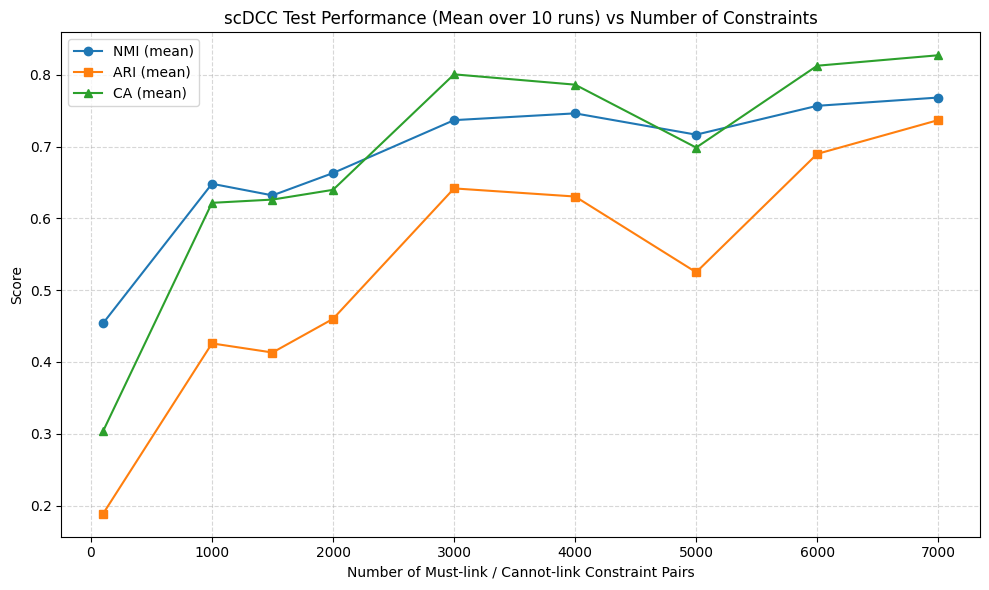

In [11]:
# =========================
# Plot scDCC Results
# =========================
plt.figure(figsize=(10,6))
plt.plot(final_df['mlcl'], final_df['NMI (mean)'], label='NMI (mean)', marker='o')
plt.plot(final_df['mlcl'], final_df['ARI (mean)'], label='ARI (mean)', marker='s')
plt.plot(final_df['mlcl'], final_df['CA (mean)'], label='CA (mean)', marker='^')
plt.legend()
plt.xlabel("Number of Must-link / Cannot-link Constraint Pairs")
plt.ylabel("Score")
plt.title("scDCC Test Performance (Mean over 10 runs) vs Number of Constraints")
plt.grid(True, alpha=0.5, linestyle='--')
plt.tight_layout()

# Create the output folder if it doesn't exist
os.makedirs(f"results/{dataset_name}", exist_ok=True)
plt.savefig(f"results/{dataset_name}/{dataset_name}_scDCC.png", dpi=350)
plt.show()

In [12]:
best = final_df.loc[final_df["CA (mean)"].idxmax()]

print(f"\n=== BEST TEST PERFORMANCE (Mean over 10 runs) ===")
print(f"ML/CL pairs: {int(best['mlcl'])}")
print(f"Test : NMI={best['NMI (mean)']:.4f}, ARI={best['ARI (mean)']:.4f}, CA={best['CA (mean)']:.4f}")


=== BEST TEST PERFORMANCE (Mean over 10 runs) ===
ML/CL pairs: 7000
Test : NMI=0.7683, ARI=0.7369, CA=0.8272


### 3.2 K-Means with PCA Preprocessing

In [13]:
# =========================
# K-Means Baseline (with PCA preprocessing)
# =========================

# --- Dimensionality reduction ---
# Reduce input dimensions to 16 using PCA 
pca = PCA(n_components=16, random_state=SEED)
X_train_np = X_train.cpu().numpy()
X_test_np = X_test.cpu().numpy()
X_pca_train = pca.fit_transform(X_train_np) # Fit PCA on train set
X_pca_test = pca.transform(X_test_np) # Apply PCA transform to test set

# --- K-Means clustering ---
kmeans = KMeans(n_clusters=len(unique_types_train), n_init=20, random_state=SEED)
kmeans_pred_train = kmeans.fit_predict(X_pca_train) # Cluster assignments for train set
kmeans_pred_test = kmeans.predict(X_pca_test) # Assign test samples to nearest cluster

# --- Convert ground-truth labels to numeric codes ---
unique_labels = np.unique(labels)
true_codes_train = np.array([np.where(unique_labels==l)[0][0] for l in labels_train])
true_codes_test = np.array([np.where(unique_labels==l)[0][0] for l in labels_test])

# --- Evaluate on test set ---
km_nmi_test = normalized_mutual_info_score(true_codes_test, kmeans_pred_test)
km_ari_test = adjusted_rand_score(true_codes_test, kmeans_pred_test)
km_acc_test = cluster_acc(true_codes_test, kmeans_pred_test)

In [14]:
# --- Validation set processing ---
X_val_np = X_val.cpu().numpy()
X_pca_val = pca.transform(X_val_np) # Apply same PCA transform to val set
kmeans_pred_val = kmeans.predict(X_pca_val) # Assign val samples to nearest cluster
true_codes_val = np.array([np.where(unique_labels==l)[0][0] for l in labels_val])

# --- Compute metrics for train set ---
km_nmi_train = normalized_mutual_info_score(true_codes_train, kmeans_pred_train)
km_ari_train = adjusted_rand_score(true_codes_train, kmeans_pred_train)
km_acc_train = cluster_acc(true_codes_train, kmeans_pred_train)

# --- Compute metrics for val set ---
km_nmi_val = normalized_mutual_info_score(true_codes_val, kmeans_pred_val)
km_ari_val = adjusted_rand_score(true_codes_val, kmeans_pred_val)
km_acc_val = cluster_acc(true_codes_val, kmeans_pred_val)

# --- Compute metrics for test set ---
km_nmi_test = normalized_mutual_info_score(true_codes_test, kmeans_pred_test)
km_ari_test = adjusted_rand_score(true_codes_test, kmeans_pred_test)
km_acc_test = cluster_acc(true_codes_test, kmeans_pred_test)

# --- Print results ---
print(f"[KMeans PCA Train] NMI={km_nmi_train:.4f}, ARI={km_ari_train:.4f}, ACC={km_acc_train:.4f}")
print(f"[KMeans PCA Val  ] NMI={km_nmi_val:.4f}, ARI={km_ari_val:.4f}, ACC={km_acc_val:.4f}")
print(f"[KMeans PCA Test ] NMI={km_nmi_test:.4f}, ARI={km_ari_test:.4f}, ACC={km_acc_test:.4f}")

[KMeans PCA Train] NMI=0.7408, ARI=0.5114, ACC=0.6455
[KMeans PCA Val  ] NMI=0.7587, ARI=0.4949, ACC=0.6265
[KMeans PCA Test ] NMI=0.7609, ARI=0.5202, ACC=0.6496


### 3.3 DEC (Deep Embedded Clustering)

In [15]:
# =========================
# Deep Embedded Clustering (DEC) with Autoencoder
# =========================

# --- Define Autoencoder architecture for DEC ---
class DEC_AE(nn.Module):
    def __init__(self, in_dim, latent_dim=20):
        super().__init__()
        # Encoder: reduces input to latent representation
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 512), nn.BatchNorm1d(512), nn.ReLU(),
            nn.Linear(512, 128), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        # Decoder: reconstructs input from latent representation
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, 512), nn.BatchNorm1d(512), nn.ReLU(),
            nn.Linear(512, in_dim)
        )
    def forward(self, x):
        z = self.encoder(x) # Latent space
        x_hat = self.decoder(z) # Reconstructed input
        return z, x_hat

# --- Convert sparse input to dense if needed ---
if scipy.sparse.issparse(X):
    X = X.toarray()

# Move full dataset to device as tensor
X_input = torch.tensor(X, dtype=torch.float32).to(device)

# Split into train/val/test tensors
X_train_tensor = X_input[train_idx]
X_val_tensor   = X_input[val_idx]
X_test_tensor  = X_input[test_idx]

# --- Initialize DEC autoencoder ---
dec_model = DEC_AE(X_train_tensor.shape[1], latent_dim=20).to(device)
dec_opt = optim.Adam(dec_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(dec_opt, step_size=100, gamma=0.5)

# --- Pretrain autoencoder using reconstruction loss ---
for epoch in range(200):
    dec_model.train(); dec_opt.zero_grad()
    z, x_hat = dec_model(X_train_tensor) 
    loss = F.mse_loss(x_hat, X_train_tensor) # Mean squared error
    loss.backward(); dec_opt.step()
    scheduler.step()

# --- Extract latent features for train set ---
dec_model.eval()
with torch.no_grad():
    z_latent_train = dec_model.encoder(X_train_tensor).cpu().numpy()

# --- K-Means clustering on latent features ---
km = KMeans(n_clusters=len(unique_types_train), n_init=30, random_state=42)
train_clusters = km.fit_predict(z_latent_train)
centers = km.cluster_centers_

# --- Assign validation and test samples to nearest cluster center ---
with torch.no_grad():
    z_latent_val  = dec_model.encoder(X_val_tensor).cpu().numpy()
    z_latent_test = dec_model.encoder(X_test_tensor).cpu().numpy()
val_dists  = cdist(z_latent_val, centers)
test_dists = cdist(z_latent_test, centers)
val_clusters  = np.argmin(val_dists, axis=1)
test_clusters = np.argmin(test_dists, axis=1)

# --- Convert string labels to numeric codes ---
unique_labels = np.unique(labels)
true_codes_train = np.array([np.where(unique_labels==l)[0][0] for l in labels_train])
true_codes_val   = np.array([np.where(unique_labels==l)[0][0] for l in labels_val])
true_codes_test  = np.array([np.where(unique_labels==l)[0][0] for l in labels_test])

# --- Clustering accuracy function ---
def cluster_acc(y_true, y_pred):
    D = max(y_true.max(), y_pred.max()) + 1
    w = np.zeros((D, D), dtype=int)
    for i in range(len(y_pred)):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(*ind)]) / len(y_true)

# --- Compute metrics for train set ---
dec_nmi_train = normalized_mutual_info_score(true_codes_train, train_clusters)
dec_ari_train = adjusted_rand_score(true_codes_train, train_clusters)
dec_acc_train = cluster_acc(true_codes_train, train_clusters)

# --- Compute metrics for validation set ---
dec_nmi_val = normalized_mutual_info_score(true_codes_val, val_clusters)
dec_ari_val = adjusted_rand_score(true_codes_val, val_clusters)
dec_acc_val = cluster_acc(true_codes_val, val_clusters)

# --- Compute metrics for test set ---
dec_nmi_test = normalized_mutual_info_score(true_codes_test, test_clusters)
dec_ari_test = adjusted_rand_score(true_codes_test, test_clusters)
dec_acc_test = cluster_acc(true_codes_test, test_clusters)

print(f"[DEC Train] NMI={dec_nmi_train:.4f}, ARI={dec_ari_train:.4f}, ACC={dec_acc_train:.4f}")
print(f"[DEC Val  ] NMI={dec_nmi_val:.4f}, ARI={dec_ari_val:.4f}, ACC={dec_acc_val:.4f}")
print(f"[DEC Test ] NMI={dec_nmi_test:.4f}, ARI={dec_ari_test:.4f}, ACC={dec_acc_test:.4f}")

[DEC Train] NMI=0.7642, ARI=0.5585, ACC=0.6917
[DEC Val  ] NMI=0.7449, ARI=0.5160, ACC=0.6585
[DEC Test ] NMI=0.7767, ARI=0.5700, ACC=0.6988


## 4. Evaluation:
In this section, we compare the test set performance of all three clustering methods — KMeans, DEC, and scDCC — using three metrics:

* NMI (Normalized Mutual Information) – measures agreement between predicted clusters and true labels, ignoring label permutations.
* ARI (Adjusted Rand Index) – evaluates similarity between clustering assignments and ground truth, adjusted for chance.
* CA (Clustering Accuracy) – matches predicted clusters to true labels using the Hungarian algorithm and measures accuracy.

In [16]:
# --- Select the best scDCC setting by highest mean Clustering Accuracy (CA) on test ---
best = final_df.loc[final_df["CA (mean)"].idxmax()]

# --- Build a summary table comparing methods on TEST metrics ---
# KMeans/DEC use the single-run test metrics computed earlier;
# scDCC uses the mean test metrics from the best-CA row (averaged over 10 repeats).
summary_test = pd.DataFrame({
    "Method": ["KMeans", "DEC", "scDCC"],
    "NMI (Test)": [km_nmi_test, dec_nmi_test, best['NMI (mean)']],
    "ARI (Test)": [km_ari_test, dec_ari_test, best['ARI (mean)']],
    "CA (Test)":  [km_acc_test, dec_acc_test, best['CA (mean)']],
})
summary_test = summary_test.sort_values(by="CA (Test)", ascending=False).reset_index(drop=True)
summary_test

,Method,NMI (Test),ARI (Test),CA (Test)
0,scDCC,0.768279,0.736878,0.827165
1,DEC,0.776699,0.570017,0.698819
2,KMeans,0.760899,0.520224,0.649606


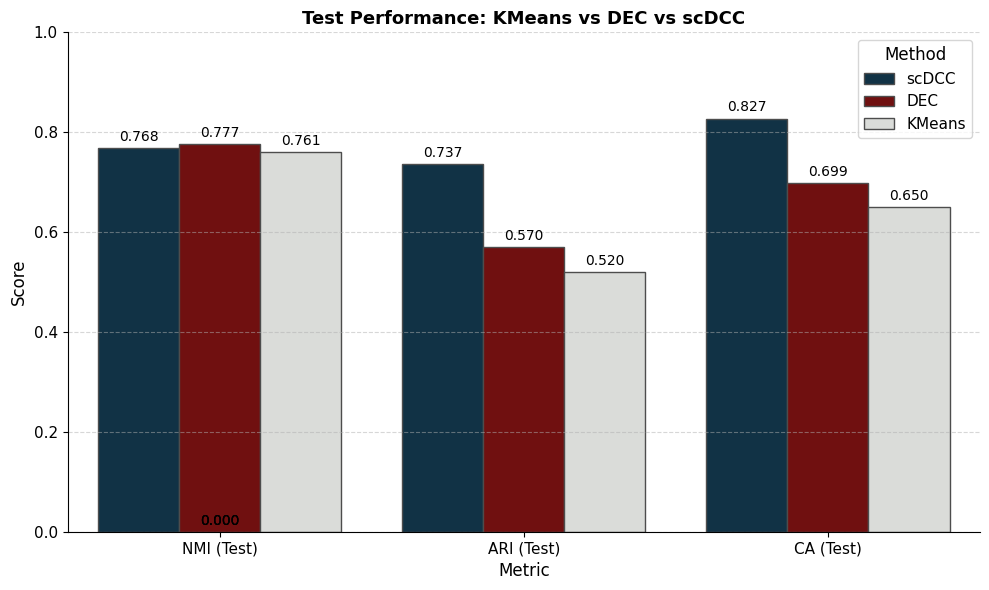

In [17]:
# =========================
# Plot: side-by-side bars of NMI / ARI / CA across methods (test set)
# =========================

# Fixed colors for each method
method_colors = {
    "KMeans": "#DADDD8",  
    "DEC":    "#800000",  
    "scDCC":  "#09344d",  
}
# Long-form table for seaborn (Metric, Score, Method)
summary_plot = pd.melt(
    summary_test,
    id_vars="Method",
    var_name="Metric",
    value_name="Score"
)

# --- Bar chart ---
plt.figure(figsize=(10,6))
ax = sns.barplot(
    x="Metric", y="Score", hue="Method",
    data=summary_plot,
    palette=method_colors,      
    edgecolor="0.3"
)

# Annotate bars with exact values (3 decimals)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height:.3f}",
        (p.get_x() + p.get_width() / 2., height),
        ha='center', va='bottom',
        fontsize=10,
        xytext=(0, 3), 
        textcoords='offset points'
    )

plt.ylim(0, 1)
plt.title("Test Performance: KMeans vs DEC vs scDCC", fontsize=13, weight="bold")
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metric", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(title="Method", fontsize=11, title_fontsize=12)
sns.despine()
plt.tight_layout()

# Create the output folder if it doesn't exist
os.makedirs(f"results/{dataset_name}", exist_ok=True)
# --- Save figure in raster (png) and vector (svg) formats for reports/publication ---
plt.savefig(f"results/{dataset_name}/{dataset_name}_comparison_plot_final.png", dpi=350)
plt.show()

## 5. Visualization:
This visualisation section compares clustering results from KMeans, DEC, and scDCC against the ground truth using UMAP projections of the dataset.

* First, predictions from each method are gathered for train, validation, and test splits and stored in the AnnData object.
* If UMAP coordinates are missing, they are computed from the data.
* A small set of must-link and cannot-link constraints are sampled and drawn as colored lines to show where the model was guided during training.
* Each panel in a 2×2 grid displays the UMAP embedding: one for ground truth labels and one for each clustering method.
* Convex hulls are drawn to outline clusters, making boundaries visually clear.
* Cluster names are annotated based on the majority ground-truth label in each predicted cluster.
* The plots are saved in both PNG and SVG formats for reporting.

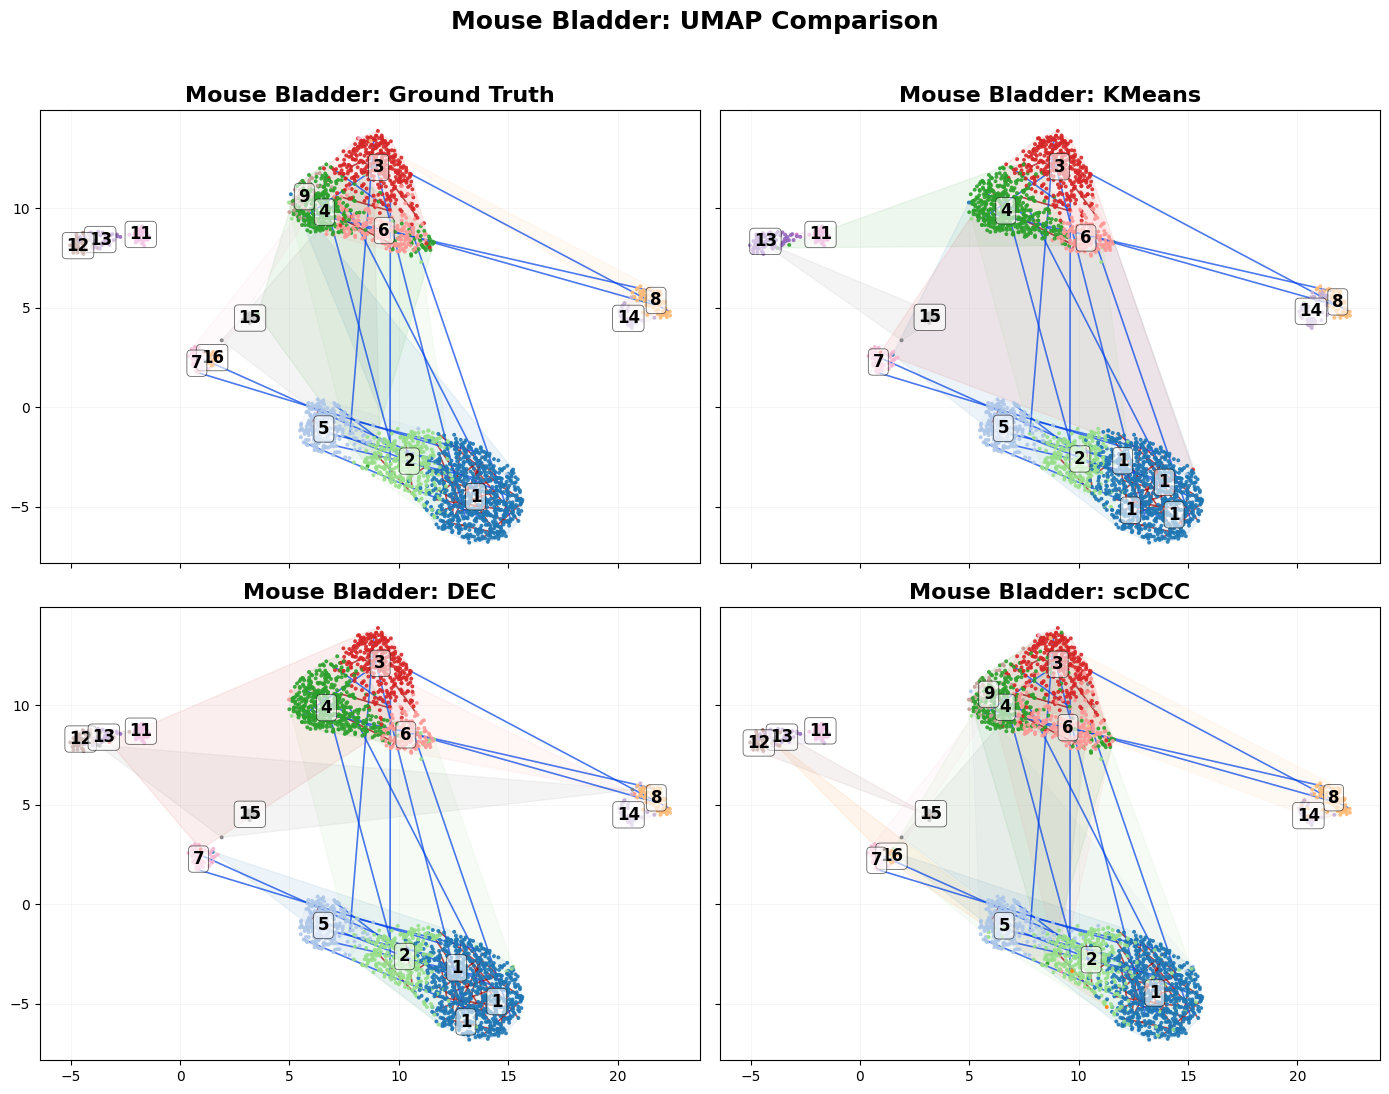

In [18]:
# ==========================================================
#                UMAP Visualization of Clustering Results
# ==========================================================
# This section generates UMAP plots for the dataset showing:
# - Ground Truth cell types
# - Clustering results from KMeans, DEC, and scDCC
# - Overlaid constraints (must-link and cannot-link pairs)
# - Hull outlines and cluster labels
# ==========================================================

# ---------- Helper function: Run scDCC once with best params ----------
def run_scdcc_once_and_predict(
    X_train, X_val, X_test, sf_train, sf_val, sf_test,
    type_to_idxs_train, unique_types_train,
    mlcl, dropout, weight_decay, device, seed=0,
    pretrain_epochs=120, dec_epochs=200
):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed); torch.cuda.manual_seed_all(seed)

    # must links 
    ml_pairs = []
    for idxs in type_to_idxs_train.values():
        if len(idxs) > 1:
            all_ml = list(combinations(idxs, 2))
            per_type = max(1, mlcl // len(unique_types_train))
            ml_pairs.extend(random.sample(all_ml, min(per_type, len(all_ml))))
    
    # cannot links 
    cl_pairs = []
    cell_types = list(type_to_idxs_train.keys())
    n_types = len(cell_types)
    per_pairtype = max(1, mlcl // (n_types * (n_types-1) // 2) if n_types > 1 else mlcl)
    for i in range(n_types):
        for j in range(i+1, n_types):
            pairs = list(product(type_to_idxs_train[cell_types[i]], type_to_idxs_train[cell_types[j]]))
            cl_pairs.extend(random.sample(pairs, min(per_pairtype, len(pairs))))
    
    # Sample the final must-link and cannot-link pairs
    ml_idx = random.sample(ml_pairs, min(len(ml_pairs), mlcl))
    cl_idx = random.sample(cl_pairs, min(len(cl_pairs), mlcl))

    # --- Initialize scDCC model ---
    model = scDCC_ZINB(X_train.shape[1], dropout_p=dropout).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=weight_decay)

    # --- Pretrain using ZINB loss ---
    for _ in range(pretrain_epochs):
        model.train(); opt.zero_grad()
        z, mu, theta, pi = model(X_train, sf_train)
        loss = zinb_nll(X_train, mu, theta, pi)
        loss.backward(); opt.step()

    # --- KMeans initialization of cluster centers ---
    model.eval()
    with torch.no_grad():
        z_pre = model(X_train, sf_train)[0].cpu().numpy()
    km = KMeans(n_clusters=len(unique_types_train), n_init=20, random_state=seed).fit(z_pre)
    model.centers.data = torch.tensor(km.cluster_centers_, dtype=torch.float32).to(device)

    # --- DEC optimization phase with constraints ---
    for _ in range(dec_epochs):
        model.train(); opt.zero_grad()
        z, mu, theta, pi = model(X_train, sf_train)
        recon_loss = zinb_nll(X_train, mu, theta, pi) # Reconstruction loss
        eps = 1e-12
        q_num = (1 + torch.cdist(z, model.centers)**2)**-1
        q = (q_num.t() / q_num.sum(1)).t() + eps
        p = (q**2 / q.sum(0) + eps); p = p / p.sum(1, keepdim=True)
        if torch.isnan(q).any():
            break
        kl_loss = F.kl_div(q.log(), p, reduction='batchmean') # KL divergence loss

        # Constraint loss (must-link & cannot-link)
        ml_sub = random.sample(ml_idx, min(len(ml_idx), 1000))
        cl_sub = random.sample(cl_idx, min(len(cl_idx), 1000))
        c_loss = contrastive_loss(z, ml_sub, cl_sub)
        
        # Total loss = reconstruction + clustering + constraints
        total_loss = recon_loss + kl_loss + 2.0*c_loss
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

    # Encode splits & predict by nearest centers fit on TRAIN
    model.eval()
    with torch.no_grad():
        z_tr, _, _, _ = model(X_train, sf_train)
        z_va, _, _, _ = model(X_val,   sf_val)
        z_te, _, _, _ = model(X_test,  sf_test)

    # --- Assign final predictions using nearest cluster centers ---
    z_tr = z_tr.cpu().numpy(); z_va = z_va.cpu().numpy(); z_te = z_te.cpu().numpy()
    km2 = KMeans(n_clusters=len(unique_types_train), n_init=20, random_state=seed).fit(z_tr)
    C = km2.cluster_centers_
    pred_tr = km2.labels_
    pred_va = np.argmin(cdist(z_va, C), axis=1)
    pred_te = np.argmin(cdist(z_te, C), axis=1)
    return pred_tr, pred_va, pred_te

# ---------- Create full-length prediction arrays for all methods ----------
N = adata_hvg.n_obs
pred_kmeans_full = np.full(N, np.nan, dtype=float)
pred_DEC_full    = np.full(N, np.nan, dtype=float)

# Fill predictions from train/val/test splits
pred_kmeans_full[train_idx] = kmeans_pred_train
pred_kmeans_full[val_idx]   = kmeans_pred_val
pred_kmeans_full[test_idx]  = kmeans_pred_test

pred_DEC_full[train_idx] = train_clusters
pred_DEC_full[val_idx]   = val_clusters
pred_DEC_full[test_idx]  = test_clusters

# ---------- Run scDCC once with best params to get preds (train/val/test) ----------
best_mlcl = int(best['mlcl'])
scdcc_tr, scdcc_va, scdcc_te = run_scdcc_once_and_predict(
    X_train, X_val, X_test, sf_train, sf_val, sf_test,
    type_to_idxs_train, unique_types_train,
    mlcl=best_mlcl, dropout=best_dropout, weight_decay=best_weight_decay,
    device=device, seed=SEED, pretrain_epochs=120, dec_epochs=200
)
pred_scdcc_full = np.full(N, np.nan, dtype=float)
pred_scdcc_full[train_idx] = scdcc_tr
pred_scdcc_full[val_idx]   = scdcc_va
pred_scdcc_full[test_idx]  = scdcc_te

# ---------- Store in AnnData for plotting ----------
adata_hvg.obs["pred_kmeans"] = pd.Series(pred_kmeans_full, index=adata_hvg.obs_names).astype("category")
adata_hvg.obs["pred_DEC"]    = pd.Series(pred_DEC_full,    index=adata_hvg.obs_names).astype("category")
adata_hvg.obs["pred_scDCC"]  = pd.Series(pred_scdcc_full,  index=adata_hvg.obs_names).astype("category")

# ---------- Compute UMAP embedding if missing ----------
sc.settings.figdir = "results/figures"
if "X_umap" not in adata_hvg.obsm:
    if "X_pca" not in adata_hvg.obsm:
        sc.pp.pca(adata_hvg)
    sc.pp.neighbors(adata_hvg)
    sc.tl.umap(adata_hvg)
xy = adata_hvg.obsm["X_umap"]

# ---------- Prepare constraints for overlay on UMAP ----------
truth_col = "cell_type"
labels_full = adata_hvg.obs[truth_col].astype(str).to_numpy()

def sample_constraints_from_split(train_index, labels, n_ml=40, n_cl=20, seed=0):
    rng = np.random.default_rng(seed)
    rel = np.arange(len(train_index))
    y = labels[train_index]
    pairs = np.array(np.meshgrid(rel, rel)).T.reshape(-1,2)
    pairs = pairs[pairs[:,0] < pairs[:,1]]
    same = pairs[y[pairs[:,0]] == y[pairs[:,1]]]
    diff = pairs[y[pairs[:,0]] != y[pairs[:,1]]]
    ml_rel = same[rng.choice(len(same), size=min(n_ml, len(same)), replace=False)] if len(same) else np.empty((0,2), int)
    cl_rel = diff[rng.choice(len(diff), size=min(n_cl, len(diff)), replace=False)] if len(diff) else np.empty((0,2), int)
    train_index = np.asarray(train_index)
    ml_abs = [(int(train_index[i]), int(train_index[j])) for i,j in ml_rel]
    cl_abs = [(int(train_index[i]), int(train_index[j])) for i,j in cl_rel]
    return ml_abs, cl_abs

try:
    must_link_pairs; cannot_link_pairs
except NameError:
    must_link_pairs, cannot_link_pairs = sample_constraints_from_split(train_idx, labels_full, n_ml=40, n_cl=20, seed=SEED)

MAX_ML, MAX_CL = 40, 20
ml_draw = must_link_pairs[:MAX_ML]
cl_draw = cannot_link_pairs[:MAX_CL]

# ---------- Define consistent colors & mapping for labels ----------
uniq_types = pd.Index(pd.unique(labels_full)).tolist()
palette = sns.color_palette("tab20", n_colors=max(20, len(uniq_types)))
type2color = {t: palette[i % len(palette)] for i, t in enumerate(uniq_types)}

# Map predicted cluster IDs to majority ground-truth cell type names
def majority_name_map(labels_pred, labels_true):
    """Map predicted cluster id -> majority ground-truth NAME (no '(cX.X)')"""
    s_pred = pd.Series(labels_pred)
    s_true = pd.Series(labels_true)
    mapping_label = {}
    mapping_color = {}
    for cl in pd.unique(s_pred.dropna()):
        mask = (s_pred == cl).to_numpy()
        if mask.sum() == 0:
            top = "UNK"
        else:
            top = str(s_true[mask].value_counts().idxmax())
        mapping_label[cl] = top       # <-- CHANGED: no '(c...)' suffix
        mapping_color[cl] = top        # color by the same GT name
    return mapping_label, mapping_color

# Create label maps for all methods
km_label_map, km_color_map   = majority_name_map(adata_hvg.obs["pred_kmeans"].to_numpy(), labels_full)
dec_label_map, dec_color_map = majority_name_map(adata_hvg.obs["pred_DEC"].to_numpy(),    labels_full)
dcc_label_map, dcc_color_map = majority_name_map(adata_hvg.obs["pred_scDCC"].to_numpy(),  labels_full)

# Get colors from label map
def colorize_by_map(labels, color_map=None):
    if color_map is None:  # ground truth: labels are true names
        names = pd.Series(labels).astype(str).to_numpy()
    else:
        names = pd.Series(labels).map(color_map).astype(str).to_numpy()
    return np.array([type2color.get(n, (0.7,0.7,0.7)) for n in names])

# ---------- Helper functions for drawing hulls, annotations, and constraint lines ----------
def line_collection(xy, pairs, color, lw=1.2, alpha=0.7, zorder=1):
    if not pairs: return None
    segs = np.array([[xy[i], xy[j]] for i,j in pairs], dtype=float)
    return LineCollection(segs, colors=[color], linewidths=lw, alpha=alpha, zorder=zorder)

def draw_hulls(ax, xy, names, alpha=0.08, lw=1.0):
    names = pd.Series(names).astype(str)
    for t in uniq_types:
        idx = np.where(names.values == t)[0]
        if len(idx) < 8: # skip very small clusters
            continue
        pts = xy[idx]
        try:
            hull = ConvexHull(pts)
            poly = plt.Polygon(pts[hull.vertices], closed=True,
                               facecolor=type2color[t], edgecolor=type2color[t],
                               alpha=alpha, linewidth=lw, zorder=0)
            ax.add_patch(poly)
        except Exception:
            pass

def annotate_cluster_names(ax, xy, labels, label_map=None, color_map=None, min_pts=1, fontsize=12):
    labs = pd.Series(labels)
    uniq = pd.unique(labs.dropna())
    for cl in uniq:
        mask = (labs == cl).to_numpy()
        if mask.sum() < min_pts:
            continue
        x = np.median(xy[mask, 0]); y = np.median(xy[mask, 1])
        text = str(cl) if label_map is None else label_map.get(cl, str(cl))
        ax.text(
            x, y, text, ha="center", va="center", fontsize=fontsize, weight="bold",
            color="black",
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="black", lw=0.6, alpha=0.6),
            zorder=4
        )

# ---------- Build 2x2 panel layout (GT, KMeans, DEC, scDCC) ----------
panels = [
    (f"{dataset_name}: Ground Truth", adata_hvg.obs[truth_col].to_numpy(), None, None),
    (f"{dataset_name}: KMeans",       adata_hvg.obs["pred_kmeans"].to_numpy(), km_label_map, km_color_map),
    (f"{dataset_name}: DEC",          adata_hvg.obs["pred_DEC"].to_numpy(),    dec_label_map, dec_color_map),
    (f"{dataset_name}: scDCC",        adata_hvg.obs["pred_scDCC"].to_numpy(),  dcc_label_map, dcc_color_map),
]

# Set consistent axis limits
xpad = (xy[:,0].max() - xy[:,0].min()) * 0.05
ypad = (xy[:,1].max() - xy[:,1].min()) * 0.05
xlim = (xy[:,0].min() - xpad, xy[:,0].max() + xpad)
ylim = (xy[:,1].min() - ypad, xy[:,1].max() + ypad)

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 11), sharex=True, sharey=True)
axes = axes.ravel()

# Loop through each panel and draw
for ax, (title, labs, lab_map, col_map) in zip(axes, panels):
    cols = colorize_by_map(labs, color_map=col_map)
    names_for_hull = labs if col_map is None else pd.Series(labs).map(col_map).to_numpy()

    draw_hulls(ax, xy, names_for_hull) # Draw convex hulls for each cluster

    # Overlay must-link and cannot-link constraints
    ml = line_collection(xy, ml_draw, color=(0.6,0.0,0.0,0.7))
    cl = line_collection(xy, cl_draw, color=(0.0,0.25,0.9,0.7))
    if ml is not None: ax.add_collection(ml)
    if cl is not None: ax.add_collection(cl)

    # Scatter plot of cells
    ax.scatter(xy[:,0], xy[:,1], c=cols, s=8, alpha=0.9, linewidths=0, zorder=2)
    
    # Annotate cluster names
    annotate_cluster_names(ax, xy, labs, label_map=lab_map, color_map=col_map, min_pts=1, fontsize=12)

    ax.set_title(title, fontsize=16, weight="bold")
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.grid(alpha=0.15, lw=0.5)
    for spine in ["top","right","left","bottom"]:
        ax.spines[spine].set_visible(True)

# # Label axes
# for i, ax in enumerate(axes):
#     if i in (2, 3): ax.set_xlabel("UMAP-1", fontsize=12)
#     if i in (0, 2): ax.set_ylabel("UMAP-2", fontsize=12)

# Main title
fig.suptitle(f"{dataset_name}: UMAP Comparison",
             fontsize=18, weight="bold", y=0.99)

# Save plots in both PNG and SVG formats
plt.tight_layout(rect=[0, 0, 1, 0.97])
os.makedirs(f"results/{dataset_name}", exist_ok=True)
plt.savefig(f"results/{dataset_name}/{dataset_name}_umap_constraints_final.png", dpi=350)
plt.show()

In [21]:
dataset_name = filename.replace("_preprocessed.h5ad", "").replace("_", " ").title()
out_dir = f"results/{dataset_name}"
os.makedirs(out_dir, exist_ok=True)
out_path = f"{out_dir}/{dataset_name}_umap_interactive.html"

def show_uniques(col):
    if col in adata_hvg.obs:
        s = adata_hvg.obs[col]
    else:
        print(f"{col} MISSING in adata_hvg.obs")

for col in ["pred_kmeans", "pred_DEC", "pred_scDCC"]:
    show_uniques(col)


def normalize_cluster_series(s):
    """Try to coerce to Int64 cluster ids; else keep as string."""
    if s is None:
        return pd.Series(["UNK"] * adata_hvg.n_obs, index=adata_hvg.obs_names)
    # convert categories to values
    if hasattr(s, "cat"):
        s = s.astype(object)
    # to numeric if possible
    s_num = pd.to_numeric(s, errors="coerce")
    if s_num.notna().any():
        return s_num.astype("Int64")  # nullable ints; NaN stays <NA>
    return s.astype(str)

def normalize_map(m):
    """Make a tolerant map that accepts int, float, and string keys."""
    if m is None:
        return {}
    out = {}
    for k, v in m.items():
        try:
            # numeric normalization
            ki = int(k)
            out[ki] = v
            out[str(ki)] = v
            out[float(ki)] = v
            out[f"{ki}.0"] = v
        except Exception:
            # keep string form
            ks = str(k)
            out[ks] = v
            # if ks looks like float int (e.g. '3.0'), also add int forms
            try:
                ki2 = int(float(ks))
                out[ki2] = v
                out[str(ki2)] = v
                out[float(ki2)] = v
                out[f"{ki2}.0"] = v
            except Exception:
                pass
    return out

def build_majority_map(cluster_series, true_names):
    """cluster id -> majority true name (robust to NaNs)."""
    mapping = {}
    s = cluster_series
    for cid in pd.unique(s.dropna()):
        mask = (s == cid).to_numpy()
        if mask.sum() == 0:
            continue
        top = Counter(true_names[mask]).most_common(1)[0][0]
        mapping[cid] = top
    return normalize_map(mapping)

def apply_mapping(series, mapping):
    """Map using tolerant mapping; fall back to original string; then fill UNK."""
    # try numeric index first
    mapped = series.map(mapping) if series.dtype.name == "Int64" else series.astype(object).map(mapping)
    # fallback with string keys
    mapped2 = series.astype(str).map(mapping)
    out = mapped2.where(mapped2.notna(), mapped)
    # final fallback: original as string
    out = out.where(out.notna(), series.astype(str))
    return out.fillna("UNK")

# Prepare label series
gt = adata_hvg.obs[truth_col].astype(str).fillna("UNK").to_numpy()

km_raw  = normalize_cluster_series(adata_hvg.obs["pred_kmeans"]  if "pred_kmeans"  in adata_hvg.obs else None)
dec_raw = normalize_cluster_series(adata_hvg.obs["pred_DEC"]     if "pred_DEC"     in adata_hvg.obs else None)
dcc_raw = normalize_cluster_series(adata_hvg.obs["pred_scDCC"]   if "pred_scDCC"   in adata_hvg.obs else None)

# Normalize supplied maps 
km_map = normalize_map(globals().get("km_label_map"))
dec_map = normalize_map(globals().get("dec_label_map"))
dcc_map = normalize_map(globals().get("dcc_label_map"))

if not km_map:
    print("km_label_map missing/empty — rebuilding from data.")
    km_map = build_majority_map(km_raw, gt)
if not dec_map:
    print("dec_label_map missing/empty — rebuilding from data.")
    dec_map = build_majority_map(dec_raw, gt)
if not dcc_map:
    print("dcc_label_map missing/empty — rebuilding from data.")
    dcc_map = build_majority_map(dcc_raw, gt)

km_lab  = apply_mapping(km_raw,  km_map)
dec_lab = apply_mapping(dec_raw, dec_map)
dcc_lab = apply_mapping(dcc_raw, dcc_map)


# DataFrame for plotting
df = pd.DataFrame({
    "UMAP1": xy[:, 0],
    "UMAP2": xy[:, 1],
    "GT":     gt,
    "KMeans": km_lab.to_numpy(),
    "DEC":    dec_lab.to_numpy(),
    "scDCC":  dcc_lab.to_numpy(),
})

print("GT uniques:    ", pd.unique(df["GT"]))
print("KMeans uniques:", pd.unique(df["KMeans"]))
print("DEC uniques:   ", pd.unique(df["DEC"]))
print("scDCC uniques: ", pd.unique(df["scDCC"]))

# Plotly figure
fig = go.Figure()

def colors_for_labels(labels):
    pal = (
        px.colors.qualitative.Alphabet
        + px.colors.qualitative.Dark24
        + px.colors.qualitative.Set3
        + px.colors.qualitative.Safe
    )
    uniq = pd.unique(labels.astype(str))
    lut = {lab: pal[i % len(pal)] for i, lab in enumerate(uniq)}
    return [lut[str(v)] for v in labels.astype(str)]

methods = [
    {"key": "GT",     "label": "Ground Truth"},
    {"key": "KMeans", "label": "KMeans"},
    {"key": "DEC",    "label": "DEC"},
    {"key": "scDCC",  "label": "scDCC"},
]
trace_idx = {}

for m in methods:
    key, label = m["key"], m["label"]
    fig.add_trace(go.Scattergl(
        x=df["UMAP1"], y=df["UMAP2"],
        mode="markers",
        marker=dict(size=4, opacity=0.9, color=colors_for_labels(df[key])),
        text=df[key],
        hovertemplate=(
            f"Method: {label}"
            "<br>Label: %{text}"
            "<extra></extra>"
        ),
        name=label,
        visible=(key == "GT")
    ))
    trace_idx[label] = len(fig.data) - 1

def segs(pairs):
    if not pairs: return ([], [])
    xs, ys = [], []
    for i, j in pairs:
        xs += [xy[i, 0], xy[j, 0], None]
        ys += [xy[i, 1], xy[j, 1], None]
    return xs, ys

ml_idx = cl_idx = None
if ("ml_draw" in globals() and ml_draw) or ("cl_draw" in globals() and cl_draw):
    xs_ml, ys_ml = segs(ml_draw if "ml_draw" in globals() else [])
    fig.add_trace(go.Scatter(
        x=xs_ml, y=ys_ml, mode="lines",
        line=dict(width=1.2, color="crimson"),
        name="Must-Link", visible=False
    ))
    ml_idx = len(fig.data) - 1

    xs_cl, ys_cl = segs(cl_draw if "cl_draw" in globals() else [])
    fig.add_trace(go.Scatter(
        x=xs_cl, y=ys_cl, mode="lines",
        line=dict(width=1.2, color="royalblue"),
        name="Cannot-Link", visible=False
    ))
    cl_idx = len(fig.data) - 1

total = len(fig.data)

def vis_for(display_label):
    v = [False] * total
    v[trace_idx[display_label]] = True
    if display_label == "scDCC" and ml_idx is not None and cl_idx is not None:
        v[ml_idx] = True; v[cl_idx] = True
    return v

buttons = [
    dict(label=m["label"], method="update",
         args=[{"visible": vis_for(m["label"])},
               {"title": f"Interactive UMAP — {m['label']}"}])
    for m in methods
]

fig.update_layout(
    title="Interactive UMAP — Ground Truth",
    xaxis_title="UMAP-1",
    yaxis_title="UMAP-2",
    template="plotly_white",
    autosize=True,
    height=None,
    width=None,
    margin=dict(l=60, r=60, t=80, b=60),  
    updatemenus=[dict(
        type="dropdown",
        x=1.05,
        y=1.0,
        showactive=True,
        buttons=buttons
    )],
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0
    )
)


fig.write_html(out_path, include_plotlyjs="cdn")
print("Saved HTML interactive to:", out_path)

GT uniques:     ['1' '5' '16' '8' '4' '2' '3' '6' '13' '14' '12' '9' '11' '7' '15']
KMeans uniques: ['1' '5' '7' '8' '4' '2' '3' '6' '15' '13' '14' '11']
DEC uniques:    ['1' '5' '7' '8' '4' '2' '3' '6' '12' '13' '14' '11' '15']
scDCC uniques:  ['1' '5' '16' '8' '4' '2' '3' '6' '13' '14' '12' '9' '11' '7' '15']
Saved HTML interactive to: results/Mouse Bladder/Mouse Bladder_umap_interactive.html


In [23]:
dash_dir = f"dash_data/{dataset_name}"
os.makedirs(dash_dir, exist_ok=True)

# Save df
df.to_csv(f"{dash_dir}/umap_labels.csv", index=False)

# Save UMAP coordinates
np.save(f"{dash_dir}/umap_coords.npy", xy)

# Save constraints
with open(f"{dash_dir}/mustlink.json", "w") as f:
    json.dump(ml_draw, f)

with open(f"{dash_dir}/cannotlink.json", "w") as f:
    json.dump(cl_draw, f)